In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,recall_score,precision_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [16]:
file_path = './data/dataset_medicaid.csv'  # Update to the correct file path
df = pd.read_csv(file_path)

In [17]:
df.set_index('CENSEOID', inplace=True)
df.drop(['CLIENTID', 'CLIENT'], axis=1, inplace=True)

In [18]:
print(df['V28HCCCODED'].value_counts())

0    397355
1      9559
Name: V28HCCCODED, dtype: int64


In [19]:
if df['V28HCCCODED'].nunique() <= 1:
    raise ValueError(
        "The dataset contains only one class. Add more diverse samples.")

In [20]:
X = df.drop('V28HCCCODED', axis=1)
y = df['V28HCCCODED']

In [21]:
age_group_col = 'MEMBERAGEGROUP'
X[age_group_col] = X[age_group_col].astype(str)

In [22]:
numerical_cols = [
    col for col in X.columns if X[col].dtype in ['int64', 'float64']]

In [23]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

In [24]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ])

C:\Users\samya\AppData\Local\Temp\ipykernel_27304\1409363210.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='MEMBERAGEGROUP', palette='coolwarm')


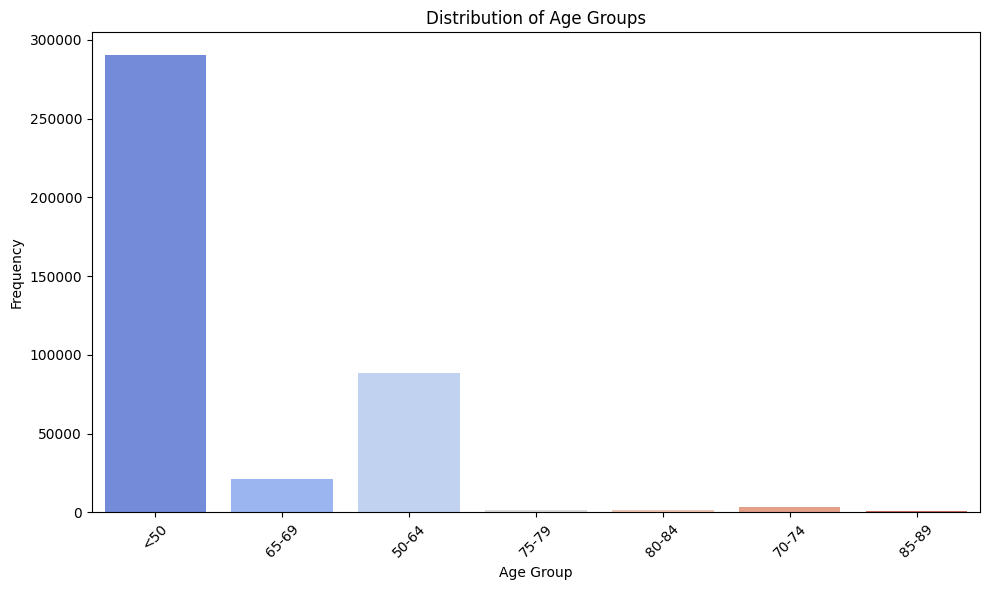

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='MEMBERAGEGROUP', palette='coolwarm')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\samya\AppData\Local\Temp\ipykernel_27304\1262842669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='V28HCCCODED', palette='viridis')


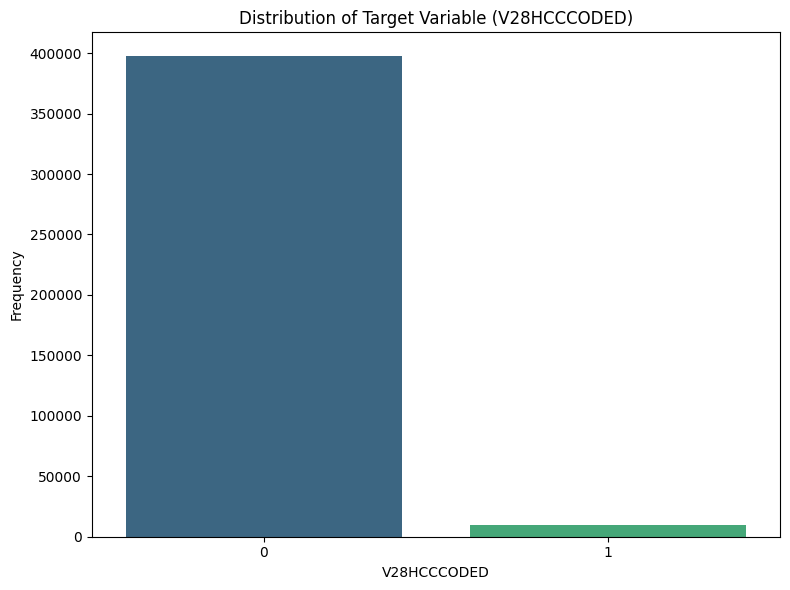

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='V28HCCCODED', palette='viridis')
plt.title('Distribution of Target Variable (V28HCCCODED)')
plt.xlabel('V28HCCCODED')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

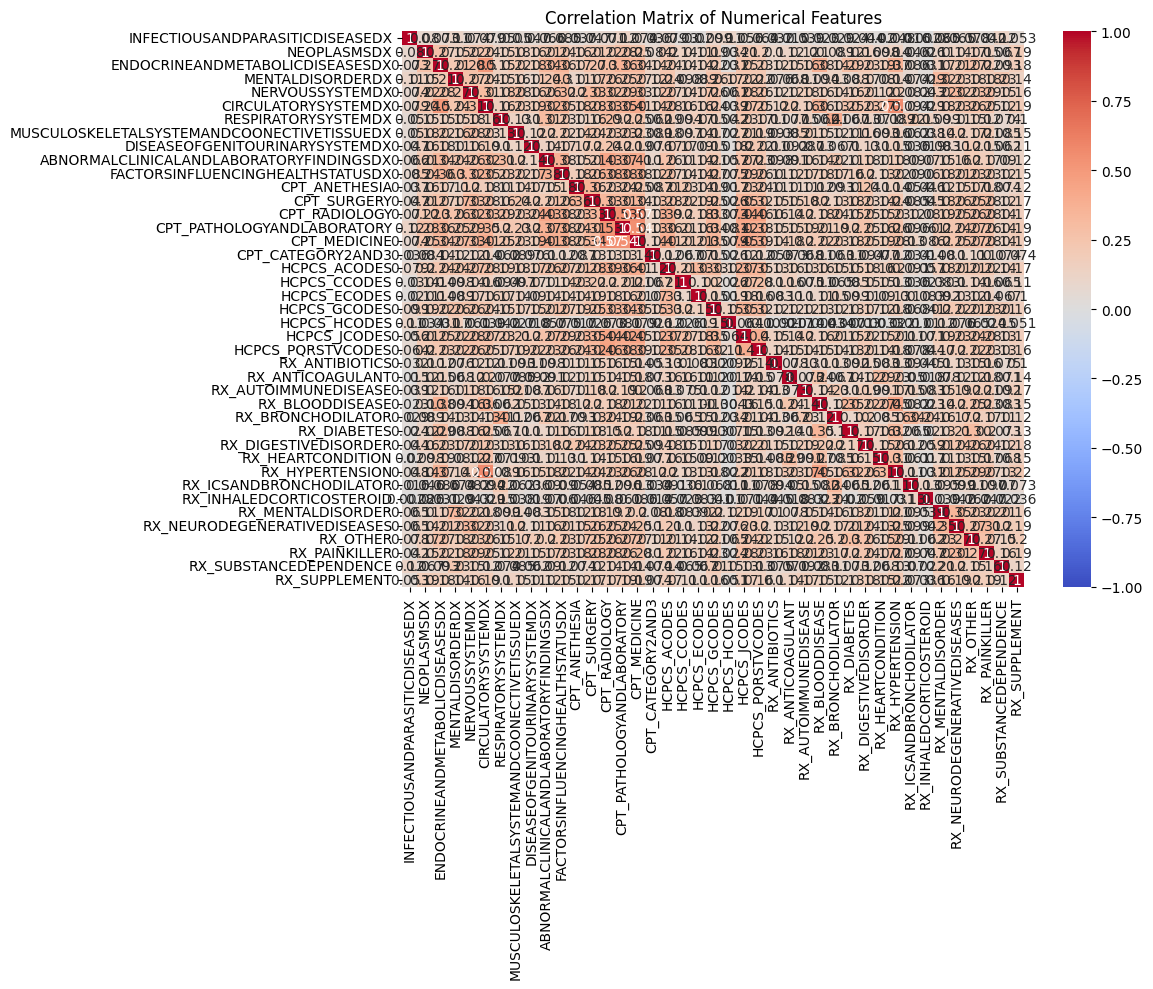

In [27]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True,
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [31]:
best_model = None
best_accuracy = 0
model_performances = {}

In [ ]:
for model_name, model in models.items():
    clf = Pipeline(
        steps=[('preprocessor', preprocessor), ('classifier', model)])
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    accuracy = scores.mean()
    model_performances[model_name] = accuracy

    # Print the accuracy, precision, and recall for each model
    print(f'{model_name} - Accuracy: {accuracy:.4f}')

    if accuracy > best_accuracy:
        best_model = clf
        best_accuracy = accuracy

Logistic Regression - Accuracy: 0.9765
Random Forest - Accuracy: 0.9756


In [ ]:
if isinstance(best_model.named_steps['classifier'], RandomForestClassifier):
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }
elif isinstance(best_model.named_steps['classifier'], LogisticRegression):
    param_grid = {
        'classifier__C': [0.1, 1.0, 10],
        'classifier__penalty': ['l2']
    }

elif isinstance(best_model.named_steps['classifier'], MLPClassifier):
    param_grid = {
        'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__alpha': [0.0001, 0.001, 0.01]
    }
elif isinstance(best_model.named_steps['classifier'], LGBMClassifier):
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [31, 50, 100]
    }
elif isinstance(best_model.named_steps['classifier'], XGBClassifier):
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7]
    }
else:
    param_grid = {}

In [ ]:
if param_grid:
    grid_search = GridSearchCV(
        best_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

In [ ]:
best_model.fit(X_train, y_train)

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import PartialDependenceDisplay

# Preprocess the categorical feature for PDP
def preprocess_categorical_for_pdp(X, feature):
    X_copy = X.copy()
    encoder = OrdinalEncoder()
    X_copy[feature] = encoder.fit_transform(X_copy[[feature]])
    return X_copy

# Partial Dependence Plot
def partial_dependence_plot(model, X, feature):
    # Preprocess the categorical feature for PDP
    X_preprocessed = preprocess_categorical_for_pdp(X, feature)

    display = PartialDependenceDisplay.from_estimator(
        model,
        X_preprocessed,  # Use the preprocessed data
        features=[feature],
        kind='average',  # Display only PDP
        grid_resolution=50
    )
    display.figure_.suptitle(f'Partial Dependence Plot for {feature}')
    display.figure_.tight_layout()

# Generate Partial Dependence Plot
print("\nGenerating Partial Dependence Plot...")
model = LGBMClassifier()

clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
clf.fit(X_train, y_train)
partial_dependence_plot(clf, X_train, 'MEMBERAGEGROUP')


In [ ]:
test_accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(
    f'\nBest Model: {best_model.named_steps["classifier"].__class__.__name__}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

In [32]:
X_processed = preprocessor.fit_transform(X)
input_shape = X_processed.shape[1]
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
from keras import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
def build_keras_model():
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
from scikeras.wrappers import KerasClassifier

print("\nTraining Keras Model...")
keras_model = KerasClassifier(build_fn=build_keras_model, epochs=10, batch_size=32, verbose=0)

# Evaluate Keras model using cross-validation
scores = cross_val_score(keras_model, X_train, y_train, cv=5, scoring='accuracy', error_score='raise')
accuracy_keras = scores.mean()
print(f'\nKeras Model Accuracy (Cross-Validation): {accuracy_keras:.4f}')
model_performances['Keras Model'] = accuracy_keras


Training Keras Model...


C:\Users\samya\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\samya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\samya\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\samya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core


Keras Model Accuracy (Cross-Validation): 0.9765


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class PyTorchNN(nn.Module):
    def __init__(self, input_size):
        super(PyTorchNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

In [ ]:
# Train PyTorch model
def train_pytorch_model(X_train, y_train, X_test, y_test):
    input_size = X_train.shape[1]
    model = PyTorchNN(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Train the model
    model.train()
    for epoch in range(10):  # Train for 10 epochs
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).round()
        accuracy = accuracy_score(y_test_tensor, y_pred)
        model_performances['PyTorch Model'] = accuracy
        print(f'PyTorch Model Accuracy: {accuracy:.4f}')
        print(classification_report(y_test_tensor, y_pred))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure X_train and X_test are DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Fit and transform the preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert processed data back to DataFrames
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Train PyTorch model
print("\nTraining PyTorch Model...")
train_pytorch_model(X_train_df, y_train, X_test_df, y_test)


In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_performances.keys()), y=list(
    model_performances.values()), palette='magma')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

[LightGBM] [Info] Number of positive: 7647, number of negative: 317884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 325531, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023491 -> initscore=-3.727373
[LightGBM] [Info] Start training from score -3.727373

Generating SHAP Analysis...


C:\Users\samya\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


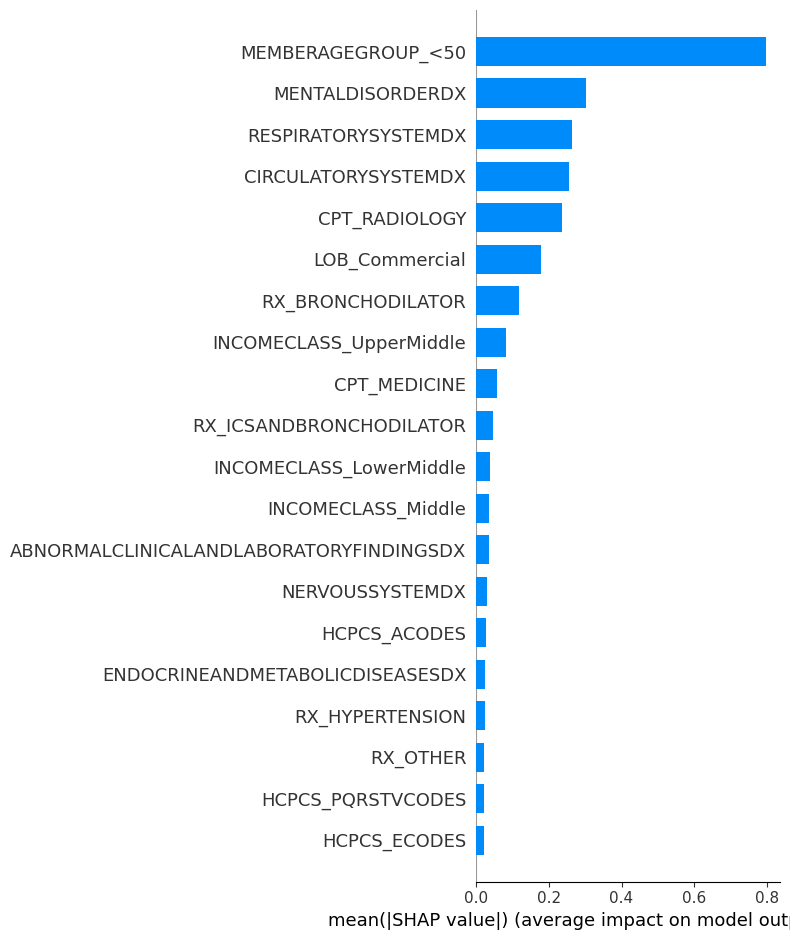

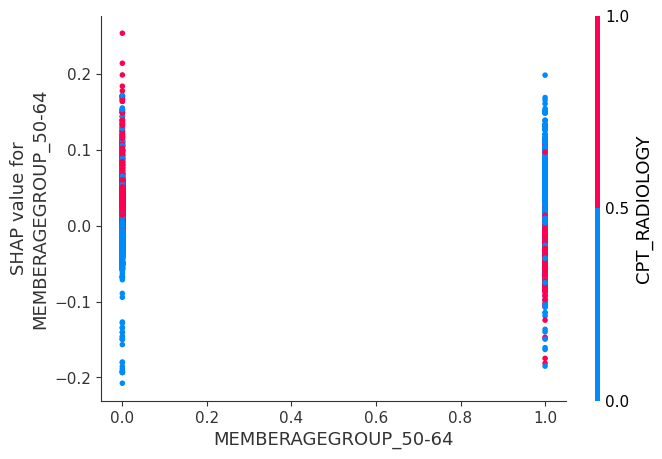

In [12]:
import shap
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming `preprocessor`, `X_train`, `y_train`, `categorical_cols`, and `numerical_cols` are defined
model = LGBMClassifier()
clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
clf.fit(X_train, y_train)

# Preprocessing function
def preprocess_data(X):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X[categorical_cols])
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
    X_numerical = X[numerical_cols]
    X_processed = pd.concat([X_numerical.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)
    return X_processed

X_train_processed = preprocess_data(X_train)
X_test_processed = preprocess_data(X_test)

# SHAP Analysis function
def shap_analysis(model, X_train, X_test):
    model_inside_pipeline = model.named_steps['classifier'] if hasattr(model, 'named_steps') else model
    explainer = shap.TreeExplainer(model_inside_pipeline)
    shap_values = explainer.shap_values(X_test)

    # Handle binary classification case
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]  # Select the SHAP values for the positive class
    base_value = explainer.expected_value

    # Generate SHAP summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    # Check and plot dependence for 'MEMBERAGEGROUP_' if present
    encoded_age_group = [col for col in X_test.columns if 'MEMBERAGEGROUP_' in col]
    if encoded_age_group:
        shap.dependence_plot(encoded_age_group[0], shap_values, X_test)

print("\nGenerating SHAP Analysis...")
shap_analysis(clf, X_train_processed, X_test_processed)


In [18]:
!pip install keras==3.6.0

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.2 MB 770.8 kB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.2 MB 1.9 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.2 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------  1.2/1.2 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import PartialDependenceDisplay

# Preprocess the categorical feature for PDP
def preprocess_categorical_for_pdp(X, feature):
    X_copy = X.copy()
    encoder = OrdinalEncoder()
    X_copy[feature] = encoder.fit_transform(X_copy[[feature]])
    return X_copy

# Partial Dependence Plot
def partial_dependence_plot(model, X, feature):
    # Preprocess the categorical feature for PDP
    X_preprocessed = preprocess_categorical_for_pdp(X, feature)

    display = PartialDependenceDisplay.from_estimator(
        model,
        X_preprocessed,  # Use the preprocessed data
        features=[feature],
        kind='average',  # Display only PDP
        grid_resolution=50
    )
    display.figure_.suptitle(f'Partial Dependence Plot for {feature}')
    display.figure_.tight_layout()

# Generate Partial Dependence Plot
print("\nGenerating Partial Dependence Plot...")
partial_dependence_plot(clf, X_train, 'MEMBERAGEGROUP')


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, cmap='Purples', fmt='d', 
            linewidths=1, linecolor='black', cbar=True)
plt.title('Confusion Matrix', fontsize=18, weight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()